# **Dataset Preprocessing for ISIC 2018 Skin Lesion Segmentation**

## Overview
This notebook handles the preprocessing of the **ISIC 2018** skin lesion segmentation dataset. The preprocessing ensures that the images and masks are properly formatted, cleaned, and optimized for training deep learning models.

## Steps Performed
1. **Mounting Google Drive**  
   - The dataset is stored in Google Drive and is mounted for access.

2. **Loading the Dataset**  
   - The ISIC 2018 dataset (images and masks) is loaded from `.zip` files and extracted to an organized directory structure.

3. **Verifying Dataset Integrity**  
   - A quick sanity check is performed to verify that the images and masks are properly aligned and correctly loaded.

4. **Resizing and Normalizing Images**  
   - All images and masks are resized to **256x256 pixels** to ensure uniform input size for deep learning models.
   - Image pixel values are normalized to the range `[0,1]` to improve model performance.
   - Masks are binarized (converted to 0 and 1 values) to ensure compatibility with segmentation models.

5. **Saving Processed Data**  
   - The preprocessed images and masks are saved as `.npy` files to reduce loading times and memory overhead.

6. **Final Verification**  
   - A few samples of preprocessed images and masks are visualized to confirm the correctness of preprocessing.

## Output
- **Processed Images:** `train_images.npy`, `val_images.npy`, `test_images.npy`
- **Processed Masks:** `train_masks.npy`, `val_masks.npy`, `test_masks.npy`
- **All saved in:** `/content/drive/MyDrive/swinunet-medical-segmentation/dataset/processed_dataset/`

## Next Steps
- The processed dataset will be used for training the **U-Net** and **Swin-Unet** segmentation models in subsequent notebooks.

# Step 1: Loading the Files

In [ ]:
import os
from google.colab import drive

# Try to detect if running in Colab
IN_COLAB = "google.colab" in str(get_ipython())

# Define dataset path
if IN_COLAB:
    print("📂 Running in Google Colab: Mounting Drive...")
    drive.mount('/content/drive')
    BASE_DIR = "/content/drive/MyDrive/swinunet-medical-segmentation/dataset"
else:
    print("💻 Running on a local machine: Set BASE_DIR manually!")
    BASE_DIR = "/path/to/local/dataset"  # Change this when running locally

# Print the dataset directory
print(f"✅ Dataset directory: {BASE_DIR}")

📂 Running in Google Colab: Mounting Drive...
Mounted at /content/drive
✅ Dataset directory: /content/drive/MyDrive/swinunet-medical-segmentation/dataset


In [ ]:
# Change directory to dataset folder
%cd /content/drive/MyDrive/swinunet-medical-segmentation/dataset

# List the contents of the dataset folder
!ls -lh

/content/drive/MyDrive/swinunet-medical-segmentation/dataset
total 28K
drwx------ 2 root root 4.0K Feb 27 08:14 processed_dataset
drwx------ 2 root root 4.0K Feb 27 07:01 test_images
drwx------ 2 root root 4.0K Feb 27 07:01 test_masks
drwx------ 2 root root 4.0K Feb 27 07:01 train_images
drwx------ 2 root root 4.0K Feb 27 07:01 train_masks
drwx------ 2 root root 4.0K Feb 27 07:01 val_images
drwx------ 2 root root 4.0K Feb 27 07:01 val_masks


# Step 2: Check the Number of Images in Each Folder

In [ ]:
# Define dataset folders
folders = ["train_images", "train_masks", "val_images", "val_masks", "test_images", "test_masks"]

# Check if folders exist and count the files
for folder in folders:
    folder_path = os.path.join(BASE_DIR, folder)
    if os.path.exists(folder_path):
        num_files = len(os.listdir(folder_path))
        print(f"📂 {folder}: {num_files} files ✅")
    else:
        print(f"❌ Folder missing: {folder_path}")

📂 train_images: 2596 files ✅
📂 train_masks: 2596 files ✅
📂 val_images: 102 files ✅
📂 val_masks: 102 files ✅
📂 test_images: 1002 files ✅
📂 test_masks: 1002 files ✅


# Step 3: Inspect a Sample Image & Mask

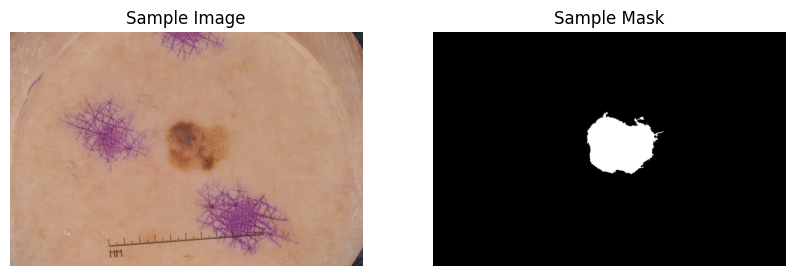

In [ ]:
import cv2 # Used for image loading and processing (OpenCV)
import numpy as np
import matplotlib.pyplot as plt

# Get only valid image files (ignoring hidden/system files)
train_images = [f for f in os.listdir(os.path.join(BASE_DIR, "train_images")) if f.endswith((".jpg", ".png", ".jpeg"))]
train_masks = [f for f in os.listdir(os.path.join(BASE_DIR, "train_masks")) if f.endswith((".png", ".jpg", ".jpeg"))]

# Select a sample image & mask
sample_image_file = train_images[0] # Pick first image
sample_mask_file = train_masks[0] # Pick first mask

# Load the image and mask
# cv2.imread() loads the image in BGR format (OpenCV default)
# cv2.IMREAD_GRAYSCALE ensures the mask is read as a single-channel grayscale image instead of a multi-channel color image
image = cv2.imread(os.path.join(BASE_DIR, "train_images", sample_image_file))
mask = cv2.imread(os.path.join(BASE_DIR, "train_masks", sample_mask_file), cv2.IMREAD_GRAYSCALE)

# Convert image to RGB for display
# OpenCV loads in BGR format, but Matplotlib expects RGB format for correct color representation
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display image and mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_rgb)
ax[0].set_title("Sample Image")
ax[0].axis("off")

ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Sample Mask")
ax[1].axis("off")

plt.show()

# Step 4: Resizing Images & Masks

Note:

Raw medical images vary in size, scale, and intensity, which can make training unstable. We’ll therefore apply the following standard preprocessing steps:

1.	Resizing Images & Masks – Ensure all inputs have the same shape (Swin-Unet expects a fixed input size).
2.	Normalization – Scale pixel values to a standard range (e.g., [0,1] or [-1,1]).
3.	Data Type Conversion – Convert images and masks to the correct format for deep learning (float tensors for images, binary masks).
4.	Augmentation (Later Step) – Introduce random transformations (flips, rotations, contrast changes) to improve generalization.

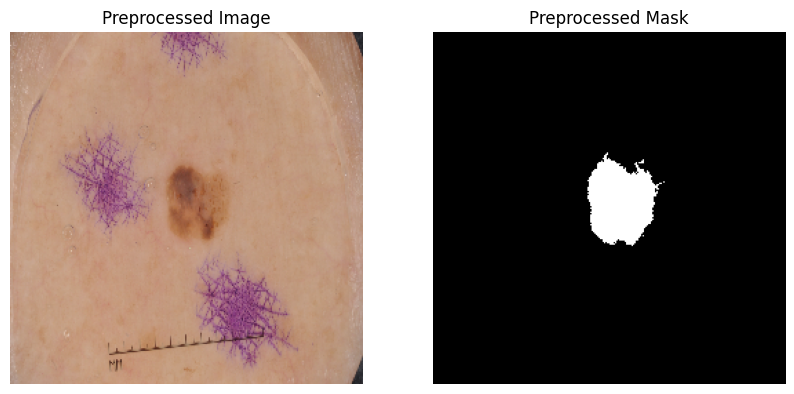

In [ ]:
# Define target image size
TARGET_SIZE = (256, 256)

def preprocess_image(image_path):
    """Load an image, resize it, and normalize pixel values."""
    image = cv2.imread(image_path)  # Load image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, TARGET_SIZE)  # Resize to target size
    image = image.astype(np.float32) / 255.0  # Normalize to [0,1] range
    return image

def preprocess_mask(mask_path):
    """Load a mask, resize it, and convert it to binary format."""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale
    mask = cv2.resize(mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)  # Resize mask
    mask = (mask > 0).astype(np.uint8)  # Convert to binary mask (0 or 1)
    return mask

# Test on a sample image & mask
sample_image = preprocess_image(os.path.join(BASE_DIR, "train_images", train_images[0]))
sample_mask = preprocess_mask(os.path.join(BASE_DIR, "train_masks", train_masks[0]))

# Display preprocessed image & mask

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample_image)
ax[0].set_title("Preprocessed Image")
ax[0].axis("off")

ax[1].imshow(sample_mask, cmap="gray")
ax[1].set_title("Preprocessed Mask")
ax[1].axis("off")

plt.show()

Code breakdown:

1. We resize images to 256×256 to make them compatible with Swin-Unet.
2. Pixel values are normalized (image.astype(np.float32) / 255.0) to stabilize training.
3. Masks are binarized ((mask > 0).astype(np.uint8)) to ensure clear segmentation labels.

# Step 5: Create a Directory for Processed Data

Note:

We make sure we save the preprocessed data so that:

1. Avoid redundant preprocessing every time we train the model.
2. peed up training by storing data in an optimized format.
3. Ensure consistency by working with the same preprocessed images every time.



In [ ]:
# Create a directory for storing processed data
processed_data_dir = os.path.join(BASE_DIR, "processed_dataset")
os.makedirs(processed_data_dir, exist_ok=True)

print(f"Processed data will be stored in: {processed_data_dir}")

Processed data will be stored in: /content/drive/MyDrive/swinunet-medical-segmentation/dataset/processed_dataset


# Step 6: Process & Save All Images and Masks

Now, we’ll loop through the entire dataset, apply our preprocessing functions, and save the results.

We will save the preprocessed images and masks in NumPy arrays (.npy files) because they load faster than raw images, use less disk space compared to storing separate .png files, and work well with deep learning frameworks like PyTorch.

In [ ]:
import shutil

# Define local storage path
local_dataset_dir = "/content/dataset"

# Copy dataset from Google Drive to Colab local storage
if not os.path.exists(local_dataset_dir):
    print("Copying dataset to local storage...")
    shutil.copytree(BASE_DIR, local_dataset_dir)
    print("✅ Copy complete!")

# Update BASE_DIR to point to local storage
BASE_DIR = local_dataset_dir

Copying dataset to local storage...
✅ Copy complete!


In [ ]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Define the folders where images and masks are stored
image_folders = ["train_images", "val_images", "test_images"]
mask_folders = ["train_masks", "val_masks", "test_masks"]

def process_and_save_data(image_folder, mask_folder, save_prefix):
    image_dir = os.path.join(BASE_DIR, image_folder)
    mask_dir = os.path.join(BASE_DIR, mask_folder)

    images, masks = [], []

    # Get only valid image files
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith((".jpg", ".png", ".jpeg"))])

    def load_and_process(img_name, mask_name):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        return preprocess_image(img_path), preprocess_mask(mask_path)

    # Use multi-threading to speed up processing
    from concurrent.futures import ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=4) as executor:
        results = list(tqdm(executor.map(load_and_process, image_files, mask_files),
                            total=len(image_files), desc=f"Processing {save_prefix}"))

    # Unzip results
    images, masks = zip(*results)

    # Convert to NumPy arrays
    images = np.array(images)
    masks = np.array(masks)

    # Save to .npy files
    np.save(os.path.join(processed_data_dir, f"{save_prefix}_images.npy"), images)
    np.save(os.path.join(processed_data_dir, f"{save_prefix}_masks.npy"), masks)

    print(f"✅ Saved {save_prefix} data: {images.shape}, {masks.shape}")

# Process all datasets
for img_folder, mask_folder, prefix in zip(image_folders, mask_folders, ["train", "val", "test"]):
    process_and_save_data(img_folder, mask_folder, prefix)

Processing train: 100%|██████████| 2594/2594 [06:51<00:00,  6.31it/s]


✅ Saved train data: (2594, 256, 256, 3), (2594, 256, 256)


Processing val: 100%|██████████| 100/100 [00:08<00:00, 11.17it/s]


✅ Saved val data: (100, 256, 256, 3), (100, 256, 256)


Processing test: 100%|██████████| 1000/1000 [01:41<00:00,  9.86it/s]


✅ Saved test data: (1000, 256, 256, 3), (1000, 256, 256)


Note: This function processes training, validation, and test images using multi-threading for efficiency. It processes images in batches instead of one-by-one, reducing bottlenecks.

In [ ]:
!ls -lh /content/drive/MyDrive/swinunet-medical-segmentation/dataset/processed_dataset

total 3.0G
-rw------- 1 root root 751M Feb 27 09:05 test_images.npy
-rw------- 1 root root  63M Feb 27 09:05 test_masks.npy
-rw------- 1 root root 1.9G Feb 27 09:03 train_images.npy
-rw------- 1 root root 163M Feb 27 09:04 train_masks.npy
-rw------- 1 root root  76M Feb 27 09:04 val_images.npy
-rw------- 1 root root 6.3M Feb 27 09:04 val_masks.npy


In [ ]:
# Detect if running in Google Colab
if "google.colab" in str(get_ipython()):
    BASE_DIR = "/content/drive/MyDrive/swinunet-medical-segmentation/dataset/processed_dataset"
else:
    BASE_DIR = "./dataset/processed_dataset"  # Adjust for local setup

# Load sample image and mask
sample_image = np.load(os.path.join(BASE_DIR, "train_images.npy"))[0]
sample_mask = np.load(os.path.join(BASE_DIR, "train_masks.npy"))[0]

print(f"Image shape: {sample_image.shape}, Mask shape: {sample_mask.shape}")

Image shape: (256, 256, 3), Mask shape: (256, 256)
